In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# K-meansスクラッチ

In [2]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        
        self.best_sse_score = None
        self.best_center = None
        
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        
        # サンプル数をセット
        self.num_samples = len(X)
        
        # 指定した回数初期値を変更して計算する
        for i in range(self.n_init):
            
            # 中心点の初期値をクラスターの数に合わせて作成
            default_center_idx   = np.random.randint(0, self.num_samples, self.n_clusters)
            self.center_clusters = np.array([X[i] for i in default_center_idx])
            
            # ラベルの初期化
#             self.labels = np.zeros(self.num_samples)
            self.labels = np.random.randint(0, self.n_clusters, self.num_samples)

            # 中心点の更新
            for _ in range(self.max_iter):
                new_center_clusters = np.array([np.average(X[self.labels == k], axis=0) 
                                                for k in range(self.n_clusters)])
                
                # 空のクラスタがあった場合は中心点をランダムな点に割り当てなおす
                for n in range(self.n_clusters):
                    if not np.any(new_center_clusters == n):
                        self.center_clusters[n] = X[np.random.choice(X.shape[0], 1), :]

                if np.allclose(self.center_clusters, new_center_clusters, atol=self.tol):
                    break
                
                self.center_clusters = new_center_clusters
                
                dist = np.array([np.linalg.norm(X- self.center_clusters[k], axis=1)
                                 for k in range(self.n_clusters)])
            
                self.labels = np.argmin(dist, axis=0)
                

            # sseを計算しベストスコアであれば更新
            new_sse_score = self._sum_squared_errors(X)
            
            if self.best_sse_score is None or self.best_sse_score > new_sse_score:
                self.best_sse_score = new_sse_score
                self.best_center = self.center_clusters
        
            #verboseをTrueにした際は学習過程を出力
            if self.verbose:
                print(f"iter{i}: sse score:", self.best_sse_score)
            
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        dist = np.array([np.linalg.norm(X - self.best_center[k], axis=1)
                         for k in range(self.n_clusters)])
        
        pred = np.argmin(dist, axis=0)
        
        return pred
    
    def _sum_squared_errors(self, X):
        """
        SSEを計算する
        """
        sse = 0
        for k in range(self.n_clusters):
            diff = X[self.labels == k] - self.center_clusters[k]
            sse += np.linalg.norm(diff)**2

        return sse
    
    def _update_centers(self, X):
        """
        中心点を更新する
        """
        new_center_clusters = np.array([np.average(X[self.labels == k], axis=0)
                                         for k in range(self.n_clusters)])
        
        dist = np.array([np.linalg.norm(X- self.center_clusters[k], axis=1)
                         for k in range(self.n_clusters)])
        labels = np.argmin(dist, axis=0)
        return labels
        

クラスタリングのための人工データセット

In [3]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

## 【問題1】中心点の初期値を決める
入力されたデータから $K$ 個の中心点 $\mu_1$ から $\mu_K$ の初期値を決めるコードを作成してください。$K$ は指定したクラスタ数です。

最もシンプルな初期値の決定方法は、データ点 $X_n$ の中からランダムに $K$ 個選ぶことです。今回はこれを実装してください。

K-meansの学習結果は中心点 $\mu$ の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

In [4]:
n_clusters = 2

default_center_idx = np.random.randint(0, len(X), n_clusters)
center_clusters = np.array([X[i] for i in default_center_idx])
center_clusters

array([[ 1.46870582,  1.86947425],
       [-1.57006498,  6.72375844]])

## 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。

K-meansはこのSSEを最小化する $r_{nk}$ と $\mu_k$ を求めることが目的となります。

複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。

$SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2$

$n$ : データ点のインデックス


$k$ : クラスタのインデックス


$X_n$ : $n$番目のデータ点


$\mu_k$ : $k$番目の中心点


$r_{nk}$ : データ点$X_n$がクラスタ$k$に所属していたら1、そうでなければ0

In [5]:
def sum_squared_errors(X, labels, center_clusters):
    num_cluster = len(center_clusters)
#     sse = np.array([np.linalg.norm(X[labels == k] - clusters_mu[k])**2 for k in range(num_cluster)]).sum()
    sse = 0
    for k in range(num_cluster):
        norm = X[labels == k] - center_clusters[k]
        sse += np.linalg.norm(norm)**2
    return sse

In [6]:
x1 = np.arange(1, 11).reshape(-1, 1)
x2 = np.arange(10, 0, -1).reshape(-1, 1)
X_test = np.concatenate([x1, x2], axis=1)

labels_test = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
cluster_centers_test = np.array([[3, 8], [8, 3]]).reshape(-1, 2)

print("X", X_test)
print("labels", labels_test)
print("mu", cluster_centers_test)

X [[ 1 10]
 [ 2  9]
 [ 3  8]
 [ 4  7]
 [ 5  6]
 [ 6  5]
 [ 7  4]
 [ 8  3]
 [ 9  2]
 [10  1]]
labels [0 0 0 0 0 1 1 1 1 1]
mu [[3 8]
 [8 3]]


In [7]:
sum_squared_errors(X_test, labels_test, cluster_centers_test)

40.00000000000001

# クラスタの割り当てと中心点の移動を繰り返す
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。


中心点 $\mu_k$ を固定した上で $SSE$ を最小化する クラスタの割り当て $r_{nk}$ を選ぶ。


クラスタの割り当て $r_{nk}$ を固定した上で $SSE$ を最小化する 中心点 $\mu_k$ を選ぶ。

最初の中心点 $\mu_k$ は問題1で作成した初期値です。


順番に見ていきます。

## 【問題3】クラスタへの割り当て
全てのデータ点 $X_n$ を最も近い中心点 $\mu_k$ に割り当てるコードを作成してください。

K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。

ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル $p,q$ に対しては以下の数式で表現できます。

$\|q-p\| = \sqrt{(q-p)\cdot(q-p)}$

NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。


numpy.linalg.norm — NumPy v1.17 Manual


中心点 $\mu_k$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

## 【問題4】中心点の移動
中心点 $\mu_k$ を $k$ 番目のクラスタに割り当てられる全てのデータ点 $X_n$ の平均値（重心）に移動するコードを作成してください。

クラスタの割り当て $r_{nk}$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

## 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。

次のどれかの条件を満たしたらこれを止めます。

繰り返しが指定した回数に到達する。（雛形では引数max_iter）
中心点 $\mu_k$ と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）

## 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。

複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 $\mu_k$ を保持しておきます。

## 【問題7】推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。

データ点 $X_n$ と学習で決まった中心点 $\mu_k$ に対し、 $SSE$ を最小化する $r_{nk}$ を選ぶ。

具体的には次のことです。

データ点 $X_n$ を最も近い $\mu_k$ に割り当てる。


C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


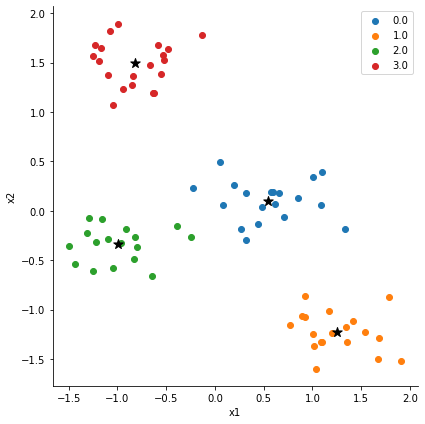

predict: [0 3 2 3 1 2 2 0 3 2 1 3 1 0 2 0 2 1 1 3 0 1 1 0 1]


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 標準化
sc = StandardScaler()
X = sc.fit_transform(X)

# データ分割
X_train, X_test = train_test_split(X)

#ハイパーパラメーター
max_iter = 50
n_init = 100
tol = 0

# 学習
km = ScratchKMeans(n_clusters=4, max_iter=max_iter, n_init=n_init, tol=tol)
km.fit(X_train)

# 可視化
df_train = pd.DataFrame(data=np.concatenate([X_train, km.labels.reshape(-1,1)], axis=1), columns=["x1", "x2", "label"])
g = sns.FacetGrid(data=df_train, hue="label", height=6)
g.map(plt.scatter, "x1", "x2")
plt.legend()
plt.scatter(km.best_center[:,0], km.best_center[:,1], marker="*", c="black", s=100)
plt.show()

# 予測
print("predict:", km.predict(X_test))

## 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 $k$ は人為的に決める必要がありますが、その判断方法としてエルボー法があります。

エルボー法により中心点の個数 $k$ を検討するためのコードを作成してください。

SSEを縦軸、クラスタ数 $k$ を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


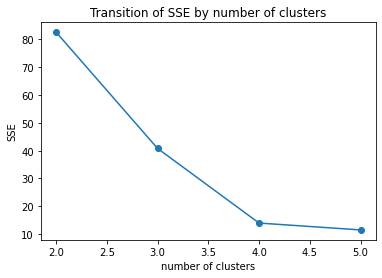

In [13]:
#ハイパーパラメーター
max_iter = 50
n_init = 100
tol = 0

#初期値
sse = []
n_cluster = list(range(2, 11))

for k in n_cluster:
    km = ScratchKMeans(n_clusters=k, max_iter=max_iter, n_init=n_init, tol=tol)
    km.fit(X)
    sse.append(km.best_sse_score)

plt.plot(n_cluster, sse, marker="o")
plt.xlabel("number of clusters")
plt.ylabel("SSE")
plt.title("Transition of SSE by number of clusters")
plt.show()


## 【問題9】（アドバンス課題）シルエット図
$k$ を決める助けになるものとしてシルエット図もあります。シルエット図を表示するコードを作成してください。

Matplotlibを使い図を表示するコードは用意しました。以下を与えてください。

silhouette_vals : shape(n_samples,)のndarray、各データ点のシルエット係数

silhouette_avg : float、シルエット係数の平均値

y_km : shape(n_samples,)のndarray、各データ点のクラスタラベル名

cluster_labels : list、クラスタのラベル名のリスト

n_clusters : int、クラスタ数

$n$ 番目のデータ点に対するシルエット係数 $s_n$ は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。

$s_n = \frac{b_n-a_n}{max(b_n,a_n)}$

$a_n$ : 凝集度。同じクラスタ内の他のデータ点との距離の平均値。

$b_n$ : 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。


乖離度 $b$ が大きく、凝集度 $a$ が小さい時が理想的であり、シルエット係数 $s$ は1に近くなります。


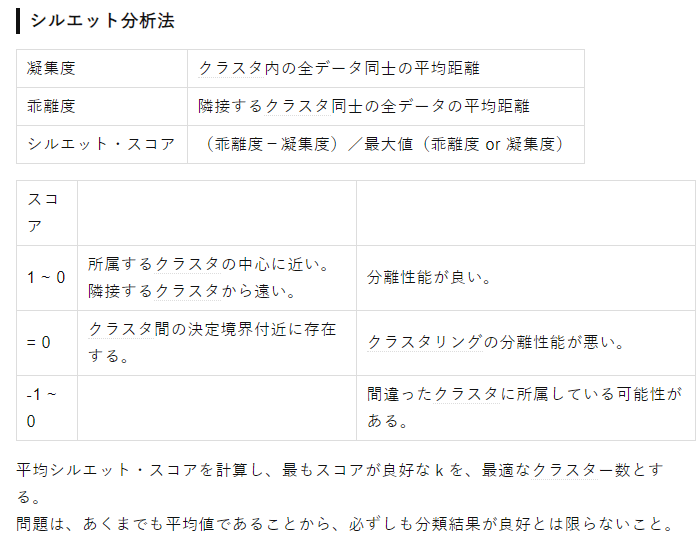

# クラスタ分析

**卸売業者のデータ分析**

クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。


UCI Machine Learning Repository: Wholesale customers Data Set


Data Folderの中からWholesale customers data.csvをダウンロードしてください。

これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。

中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。

顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

1) FRESH: 生鮮品の年間支出額

2) MILK: 乳製品の年間支出額

3) GROCERY: 食料雑貨の年間支出額

4) FROZEN: 冷凍食品の年間出資額

5) DETERGENTS_PAPER: 衛生用品と紙類の年間支出額

6) DELICATESSEN: 惣菜の年間支出額

7) CHANNEL: 販売チャネル（１＝ホテル・レストラン・カフェ、2=個人向け）

8) REGION: 各顧客の地域（1＝リスボン、２＝ポルト、３＝そのほか）

In [16]:
data_all = pd.read_csv("Wholesale customers data.csv")
data_all.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [17]:
data = data_all.drop(columns=["Channel", "Region"])

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


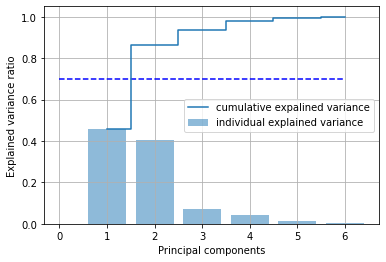

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

## 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 $k$ を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

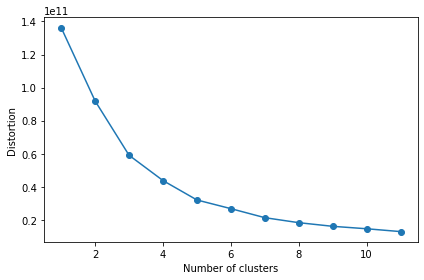

In [20]:
from sklearn.cluster import KMeans

distortions = []
for i in range(1,12):
    km = KMeans(n_clusters=i,
                n_init=10,
                max_iter=350,
                random_state=0)
    y_km = km.fit_predict(data_pca)
    km.fit(data_pca)
    distortions.append(km.inertia_)
plt.plot(range(1, 12), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

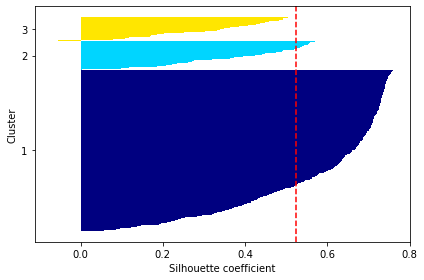

In [21]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=350,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(data_pca)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(data_pca, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

クラスタ数はＫ＝５を選択した。

理由は以下の通り。

* 以上のエルボー法、シルエット図の結果よりクラスタ数が３～６の場合に比較的適切なクラスタ数になりそう。

* クラスタ数が多いほど、そのグループの特徴の説明や意味づけが難しくなる。分析した結果を卸売業者へ説明責任があることを考えると結果が大きく変わらない場合には極力少ないクラスタ数を選択する方が分かりやすいと考えたから。

## 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。

クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

In [22]:
#データをひとつにまとめる
df_pca = pd.DataFrame(np.concatenate([data_all[["Channel","Region"]] ,data_pca, y_km[:, np.newaxis]], axis=1),
                      columns=["Channel", "Region", "x1", "x2", "cluster"])
df_pca.head()

,Channel,Region,x1,x2,cluster
0,2.0,3.0,650.022122,1585.519090,0.0
1,2.0,3.0,-4426.804979,4042.451509,0.0
2,2.0,3.0,-4841.998707,2578.762176,0.0
3,1.0,3.0,990.346437,-6279.805997,0.0
4,2.0,3.0,10657.998731,-2159.725815,1.0


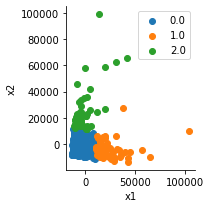

In [23]:
#クラスタを可視化
g = sns.FacetGrid(df_pca, hue="cluster")
g.map(plt.scatter, "x1", "x2")
plt.legend()
plt.show()

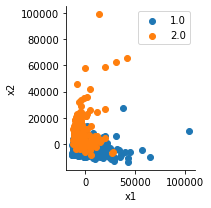

In [24]:
#Channelの分布を可視化
g = sns.FacetGrid(df_pca, hue="Channel")
g.map(plt.scatter, "x1", "x2")
plt.legend()
plt.show()    


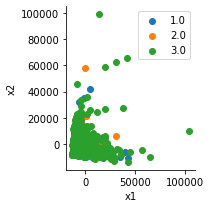

In [25]:
#Regionの分布を可視化
g = sns.FacetGrid(df_pca, hue="Region")
g.map(plt.scatter, "x1", "x2")
plt.legend()
plt.show()    

### 【考察・説明】
クラスタリングはデータ同士の類似性に基づきグルーピングしたものであり、グループの特徴や意味付けは後から人間によって考察され与えられるものである。データ起点のグルーピング。

既知のグループ（地域、販売チャネル）はある事実に基づきデータ観測時に分類されるグループであり、データ観測時点から意味を与えられたものであるため、クラスタとはその性格が異なり、必ずしもグループ間にデータ上の有意差がないこともありえる。

## 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

《ヒント》

前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。


条件ごとにデータを見る際にはPandasのgroupbyが便利です。

### 【はじめに】データの概観を把握する

In [26]:
#総売上の列を追加
data_all["Total_Sales"] = data_all[['Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen']].sum(axis=1)


In [27]:
data_all.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total_Sales
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455,33226.136364
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937,26356.301730
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,904.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000,17448.750000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000,27492.000000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000,41307.500000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000,199891.000000


基本統計量より分かること

* 販売チャネルはHoreca（レストラン・カフェ・ホテル）など業者向けのデータが半数以上を占める
* 地域はリスボン・ポルト以外のその他地域のデータで半数以上を占める
* 各販売品とも平均値と最大値に大きく乖離があることから、一部の大口の取引があり、左に偏った分布をしていると予想される
* 生鮮食品 ＞ 食料品 ＞ 冷凍食品 ＞ 乳製品 ＞ 惣菜 ＞ 衛生用品 の売り上げ順
* 各商材の売上の積み上げと総売上の最小値は乖離しているため、特定の品を大きく取引する顧客が多い

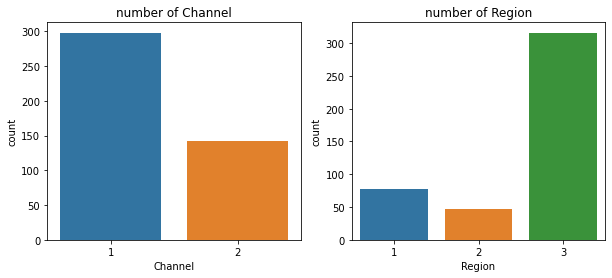

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x="Channel", data=data_all, ax=axes[0])
sns.countplot(x="Region", data=data_all, ax=axes[1])
axes[0].set_title("number of Channel")
axes[1].set_title("number of Region")
plt.show()

### 【分析１】地域・販売チャネル毎の総売上高の調査

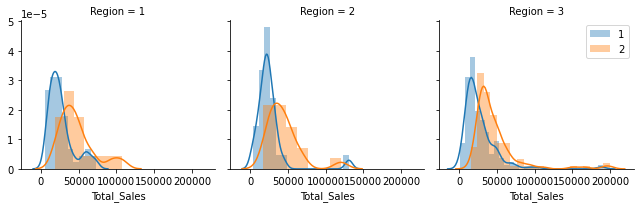

In [29]:
g = sns.FacetGrid(data_all, hue="Channel", col="Region" )
g.map(sns.distplot,"Total_Sales")
plt.legend()
plt.show()

* ポルト市はホレカの売上割合が高い。他の地域は同程度くらい
* どの地域でも販売チャネルが小売店の方が売上高が大きい傾向にある

### 【分析２】地域・商材毎の売上

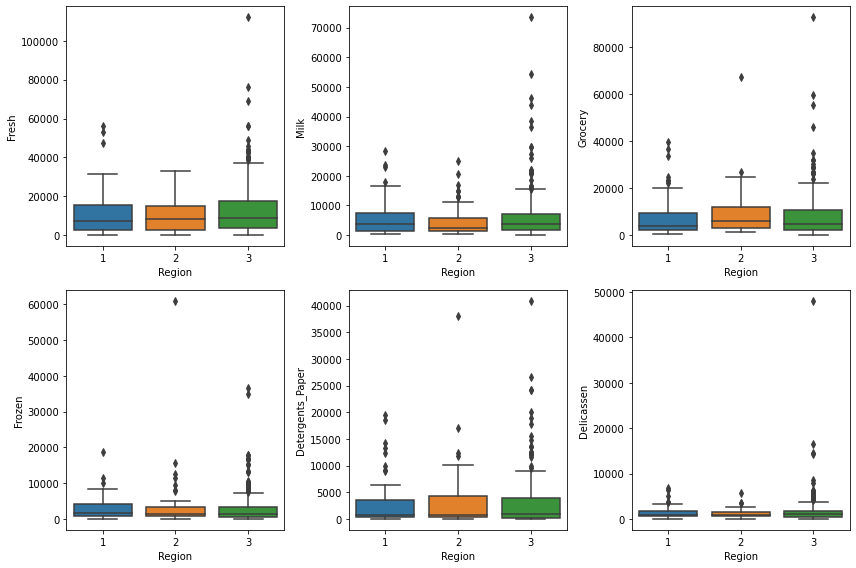

In [30]:
col = ["Fresh", "Milk", "Grocery" ,"Frozen", "Detergents_Paper", "Delicassen"]

fig, axes = plt.subplots(2, 3, figsize=(12,8))

for i, c in enumerate(col):
    sns.boxplot(x="Region", y=c, data=data_all, ax=axes[int(i/3), i%3])
    
plt.tight_layout()
plt.show()

・地域による商材毎の売上高にほとんど差はない

### 【分析３】販売チャネル・商材毎の売上

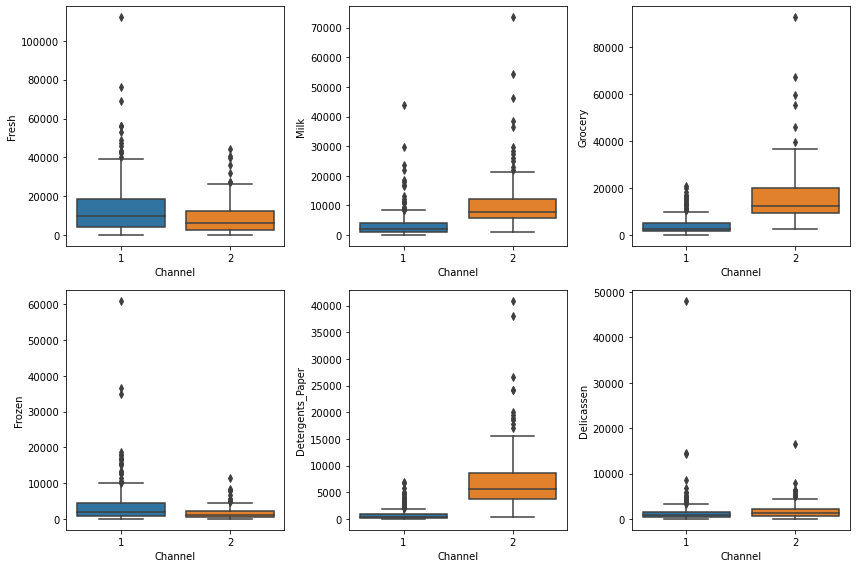

In [31]:
col = ["Fresh", "Milk", "Grocery" ,"Frozen", "Detergents_Paper", "Delicassen"]

fig, axes = plt.subplots(2, 3, figsize=(12,8))

for i, c in enumerate(col):
    sns.boxplot(x="Channel", y=c, data=data_all, ax=axes[int(i/3), i%3])
    
plt.tight_layout()
plt.show()

* 乳製品・食料雑貨・衛生用品などは小売店への売上高が高い
* 生鮮食品・冷凍食品はホレカの方が売上が高い

### 【分析４】クラスタ分析

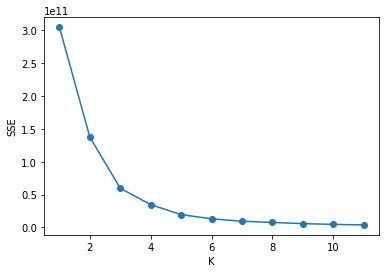

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data_c = data_all.copy()

num_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper', 'Delicassen']

#標準化
sc = StandardScaler()
data_c[num_cols] = sc.fit_transform(data_c[num_cols])

#クラスタリング
objective_vals = []
K = range(1, 12)
for k in range(1, 12):
    km = KMeans(n_clusters=k, n_init=30, max_iter=200, tol=1e-4, random_state=0)
    km = km.fit(data_c)
    objective_vals.append(km.inertia_)

plt.plot(K, objective_vals, marker="o")
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()

K=3
あたりが適当そう

In [33]:
pred = KMeans(n_clusters=3, n_init=50, max_iter=200, tol=1e-4, random_state=0).fit_predict(data_c)
data_all["cluster"] = pred
data_all.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total_Sales,cluster
0,2,3,12669,9656,7561,214,2674,1338,34112,0
1,2,3,7057,9810,9568,1762,3293,1776,33266,0
2,2,3,6353,8808,7684,2405,3516,7844,36610,0
3,1,3,13265,1196,4221,6404,507,1788,27381,0
4,2,3,22615,5410,7198,3915,1777,5185,46100,2


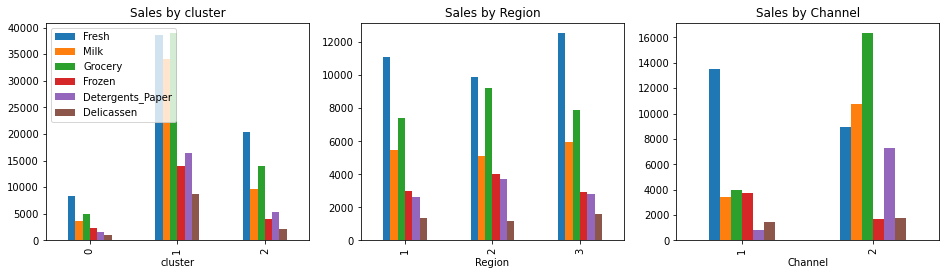

In [34]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

data_all.groupby(["cluster"]).mean().drop(columns=["Channel", "Region", "Total_Sales"]).plot.bar(ax=axes[0], legend=True)
data_all.groupby(["Region"]).mean().drop(columns=["Channel", "cluster", "Total_Sales"]).plot.bar(ax=axes[1], legend=False)
data_all.groupby(["Channel"]).mean().drop(columns=["Region", "cluster", "Total_Sales"]).plot.bar(ax=axes[2], legend=False)
axes[0].legend(loc="upper left")
axes[0].set_title("Sales by cluster")
axes[1].set_title("Sales by Region")
axes[2].set_title("Sales by Channel")
plt.show()

以上の図より、クラスタは顧客を売上規模に応じてグルーピングしたことが予想できる （０：小規模、２：中規模、１：大規模）  
最後に、各クラスター毎の売上構成を確認してみる

In [35]:
pd.set_option('precision', 2)

sales_ratio = data_all.groupby("cluster").sum()[num_cols].apply(lambda x:x / data_all.groupby("cluster").sum()["Total_Sales"])
sales_ratio

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,
0,0.38,0.16,0.22,0.11,0.07,0.05
1,0.26,0.23,0.26,0.09,0.11,0.06
2,0.37,0.17,0.25,0.07,0.10,0.04


### 【総論】
以上の分析結果より以下のことが分かる。
* <u>販売チャネルによって売れ筋の商品が異なる</u>

　　⇒販売チャネルに応じた商品の取捨選択、マーケティング、余計なコストカットができるところはないか  
  　　　今回のデータにはないが、売上数量や原価が分かるとより具体的な戦略が打ち出せそう
    
* <u>小売店への売上の方がホレカより売上規模が大きい</u>

　　⇒小売店の顧客数もホテル・レストランに比べてまだまだ少ないので、  
  　　　小売店への販売チャネルの規模拡大で売上増が見込めるのではないか

* <u>売上規模が大きいクラスタについて、「生鮮品」の全体の売上に占める割合が他のクラスタと比べて低い</u>

　　⇒要因分析する価値はありそう。  
  　　　そもそもクラスタに属するサンプル数が低いため正確な判断をするにはもっとデータが必要ともいえる。


## 【問題13】（アドバンス課題）他の手法の調査
今回扱ったK-means以外に非階層クラスタリングで有名な手法としては DBSCAN 、

PCA以外に次元削減手法で有名な手法としては t-SNE や LLE があります。

* DBSCANのメリット・デメリット
* t-SNE、LLEのメリット・デメリット

について記述してください。

### まずはじめに

まず、「主成分分析」や「多次元尺度構成法」は線形変換を前提としているため、

非線形な高次元データを低次元データに上手く落とし込むことができません。

また、「Isomap」や「LLE」は、データの局所的な構造と大局的な構造を、同時に低次元データへと表現することが難しいことが知られています。

[まとめ](https://www.hellocybernetics.tech/entry/2017/07/06/133450)

### DBSCANとは

DBSCAN (Density-based spatial clustering of applications with noise ) は、1996 年に Martin Ester, Hans-Peter Kriegel, Jörg Sander および Xiaowei Xu によって提案された密度準拠クラスタリングのアルゴリズムです。半径以内に点がいくつあるかでその領域をクラスタとして判断します。近傍の密度がある閾値を超えている限り，クラスタを成長させ続けます。半径以内に近く点がない点はノイズになります。

**長所**
1. k-meansと違って，最初にクラスタ数を決めなくてもクラスターを作成できます。
2. とがったクラスターでも分類できます。クラスターが球状であることを前提としない。
3. 近傍の密度でクラスターを判断します。

**短所**
1. border点の概念が微妙で，データによりどのクラスタに属するか変わる可能性があります。
2. データがわからないとパラメータを決めるのが難しいです。

**重要パラメーター**
1. eps：ある点から近くの点を探すときの半径距離
2. min_samples：クラスタと判定するときに、半径範囲に含まれる点の数

**めっちゃ分かりやすい解説ページ**

[DBSCAN解説ページ](https://data-analysis-stats.jp/python/dbscan%e3%82%af%e3%83%a9%e3%82%b9%e3%82%bf%e3%83%bc%e3%81%ae%e8%a7%a3%e8%aa%ac%e3%81%a8%e5%ae%9f%e9%a8%93/)


### t-SNEとは

高次元空間上で非線形な構造を保持しているデータに対して、類似性を損ねることなく低次元化できる手法

**t-SNEを理解する上でポイント**
1. t-SNEでの次元削減の考え方: 近くの点との関係性をなるべく維持するように非線型変換。
2. データ同士の関係性の表現手法: 確率分布を用いて点同士の関係を表現。
3. 分布の最適化: コスト関数に高次元-低次元で対応する同じ点同士のKLダイバージェンスを使用。

**重要パラメータ**

perplecity：データ同士の関係の評価の際にどれだけ近傍の点を考慮するかの決定に寄与する

**長所**
* 高次元の局所的な構造を非常によく捉える
    
**短所**
* Perplexity（ハイパーパラメーター）によってクラスタが全く異なってしまう
* ローカルな情報に忠実だが、グローバルな情報を一切保持できない
　特徴量空間上の位置関係などは保持できない

**利用場面**
* かなり高次元なデータを２次元や３次元に落として、クラス間の関係性を可視化したい場合など
   

### LLEとは

多様体学習と呼ばれるアプローチをとる手法。  
局所的に低次元の超平面とみなせる図形のを見つけて、低次元化する手法

**メリット**
* 非線形なデータに対しても類似性を損ねることなく低次元化できる

**デメリット**
* 多様体が複数ある場合、互いに位置関係をうまく保存できない
* 圧縮後のデータ位置を再構成する計算量がデータ数の2乗に比例するため、大規模データに適用しづらい

## 【問題14】（アドバンス課題）t-SNEとDBSCANの利用
Wholesale customersのデータに対して、PCAではなく、 t-SNE を用いて次元削減をしてください。さらにK-meansではなく、 DBSCAN を用いてクラスタリングしてください。


そのクラスタリング結果をPCA+kmeansの場合の結果と比較してみましょう。実装にはscikit-learnを用いてください。

[sklearn.manifold.TSNE — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[sklearn.cluster.DBSCAN — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)


《パラメーターチューニング》

これらはK-meansやPCAに比べパラメーターチューニングが難しい手法です。

scikit-learnのドキュメントと共に論文も参考にしながらパラメータの意味を確認することも大切になります。

In [215]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

data_all = pd.read_csv("Wholesale customers data.csv")

#カテゴリ列は除く
data = data_all.drop(columns=["Channel", "Region"])

sc = StandardScaler()
data = sc.fit_transform(data)

data_embedded = TSNE(n_components=2, perplexity=50).fit_transform(data)

clustering = DBSCAN(eps=1.5, min_samples=5)
clustering.fit(data_embedded)

cluster_labels = clustering.labels_.reshape(-1, 1)
data_embedded = np.concatenate([data_embedded, cluster_labels], axis=1)
cluster, _ = np.unique(cluster_labels, return_counts=True)
cluster, _

(array([-1,  0,  1,  2], dtype=int64),
 array([ 24, 120, 289,   7], dtype=int64))

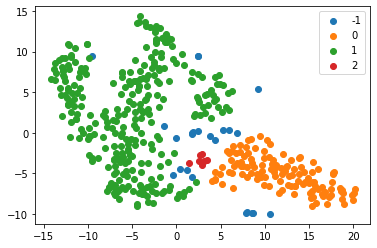

In [216]:

for y in cluster:
    y_filter = data_embedded[:, 2] == y
    plt.scatter(data_embedded[y_filter, 0], data_embedded[y_filter, 1], label=str(y))

plt.legend()
plt.show()